In [22]:
import pandas as pd
import numpy as np
import math

from tqdm import tqdm
import time

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [2]:
RANDOM_SEED = 13022022

In [3]:
test = pd.read_csv('Task/test.csv')
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Smiles  1614 non-null   object
dtypes: object(1)
memory usage: 12.7+ KB


In [5]:
test.sample(3)

,Smiles
1285,CCCOc1ccc(/C=C2/SC(=O)NC2=O)cc1
581,O=C(O)CCCNC(=O)c1cccnc1
749,CN1CCN(CCCCN2C(=O)CN(/N=C/c3ccc(-c4ccc(Cl)cc4)...


In [6]:
train = pd.read_csv('Task/train.csv')
train.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Smiles  5557 non-null   object
 1   Active  5557 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 49.0+ KB


In [8]:
train.sample(3)

,Smiles,Active
2884,CC(O)CC(=O)O,False
1266,OCc1c[nH]cn1,False
953,O=C(O)c1ccc(S(=O)(=O)N(Cc2ccc(OC(F)(F)F)cc2)c2...,False


In [9]:
list(train['Active'].unique())

[False, True]

In [10]:
list_active = {False: 0, True: 1}

In [11]:
train['Active'] = train['Active'].map(list_active)

In [12]:
train.sample()

,Smiles,Active
68,CCCCCCOc1nsnc1C1=CCCN(C)C1.O=C(O)C(=O)O,0


In [13]:
train['train'] = 1
test['train'] = 0

In [14]:
df = pd.concat([train, test], ignore_index=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7171 entries, 0 to 7170
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Smiles  7171 non-null   object 
 1   Active  5557 non-null   float64
 2   train   7171 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 168.2+ KB


In [16]:
df['train'].unique()

array([1, 0], dtype=int64)

In [17]:
df[df['train'] == 1]['Active'].value_counts()

0.0    5351
1.0     206
Name: Active, dtype: int64

In [18]:
from collections import Counter

atoms = Counter()
for i in df['Smiles'].unique():
    for j in i:
        atoms[j] += 1

In [19]:
len(atoms.keys())

45

In [20]:
cont = 0
for i in atoms.keys():
    new_value = len(atoms.keys()) - cont
    atoms[i] = new_value
    cont += 1

In [21]:
atoms

Counter({'C': 45,
         'O': 44,
         'c': 43,
         '1': 42,
         '2': 41,
         '[': 40,
         'n': 39,
         'H': 38,
         ']': 37,
         '(': 36,
         'N': 35,
         ')': 34,
         '@': 33,
         '.': 32,
         'l': 31,
         '=': 30,
         'S': 29,
         '3': 28,
         '4': 27,
         'F': 26,
         '-': 25,
         's': 24,
         '/': 23,
         '5': 22,
         'o': 21,
         'a': 20,
         '+': 19,
         '#': 18,
         'I': 17,
         'P': 16,
         'B': 15,
         'r': 14,
         '\\': 13,
         'Z': 12,
         '6': 11,
         '7': 10,
         '8': 9,
         'e': 8,
         'A': 7,
         'K': 6,
         'M': 5,
         'g': 4,
         'i': 3,
         'L': 2,
         '9': 1})

In [22]:
df['len'] = df['Smiles'].apply(lambda x: len(x))

In [23]:
df['1'] = df['Smiles'].apply(lambda x: list(x))

In [24]:
df.sample(3)

,Smiles,Active,train,len,1
1161,CC(CC(C(N)=O)(c1ccccc1)c1ccccc1)N(C)C.O=S(=O)(O)O,0.0,1,49,"[C, C, (, C, C, (, C, (, N, ), =, O, ), (, c, ..."
868,Cc1cc(C(=O)Nc2cc(Oc3ccc4nc(NC(=O)C5CC5)cn4n3)c...,0.0,1,57,"[C, c, 1, c, c, (, C, (, =, O, ), N, c, 2, c, ..."
3274,COc1ccc(Cl)cc1NC(=O)Nc1cc(C)nc2ccccc12,0.0,1,38,"[C, O, c, 1, c, c, c, (, C, l, ), c, c, 1, N, ..."


In [25]:
df['len'].unique().max()

707

In [26]:
new_df = pd.DataFrame()
for i in tqdm(range(len(df['1']))):
    e = pd.DataFrame(df.loc[i].explode())
    e.reset_index(drop=True, inplace=True)
    e = e.T
    new_df = pd.concat([new_df, e], ignore_index = True)

100%|██████████████████████████████████████████████████████████████████████████████| 7171/7171 [07:26<00:00, 16.04it/s]


In [27]:
new_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,701,702,703,704,705,706,707,708,709,710
853,CC(C)=CCc1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(C(F)(F)...,0,1,56,C,C,(,C,),=,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3086,Oc1cc2c(cc1O)CN(C(=S)NCCc1ccc(Cl)cc1)CCC2,1,1,41,O,c,1,c,c,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2309,Cn1sc(=O)n(Cc2ccccc2)c1=O,1,1,25,C,n,1,s,c,(,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,C=CCc1ccccc1OCC(O)CNC(C)C.Cl,0,1,28,C,=,C,C,c,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5264,CCn1cc(C(=O)O)c(=O)c2cc3c(cc21)OCO3,0,1,35,C,C,n,1,c,c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
new_df.fillna(0, inplace = True)

In [29]:
new_df.rename(columns = {0: 'Smiles', 1: 'Active', 2: 'train', 3: 'len'}, inplace = True)
new_df = new_df.astype({"Active": "Int64"})

In [30]:
new_df.set_index(['Smiles', 'Active', 'train', 'len'], inplace = True)

In [31]:
new_df.sample(5)

,,,,4,5,6,7,8,9,10,11,12,13,...,701,702,703,704,705,706,707,708,709,710
Smiles,Active,train,len,,,,,,,,,,,,,,,,,,,,,
Oc1ccc([C@H]2COc3cc(O)ccc3C2)cc1,0,1,32,O,c,1,c,c,c,(,[,C,@,...,0,0,0,0,0,0,0,0,0,0
O=C(O)c1ccccc1C(=O)Nc1ccc(-c2ccccc2)cc1,0,1,39,O,=,C,(,O,),c,1,c,c,...,0,0,0,0,0,0,0,0,0,0
Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,1,1,48,C,c,1,c,(,O,C,C,(,F,...,0,0,0,0,0,0,0,0,0,0
Cc1ccc(C(=O)C(C)CN2CCCCC2)cc1,0,1,29,C,c,1,c,c,c,(,C,(,=,...,0,0,0,0,0,0,0,0,0,0
Br.CCSC(=N)N,0,1,12,B,r,.,C,C,S,C,(,=,N,...,0,0,0,0,0,0,0,0,0,0


In [32]:
from tqdm import tqdm
import time

for i in tqdm(range(len(new_df[4]))):
    new_df.iloc[i] = new_df.iloc[i].map(atoms)

100%|█████████████████████████████████████████████████████████████████████████████| 7171/7171 [00:13<00:00, 535.90it/s]


In [33]:
new_df.sample(5)

,,,,4,5,6,7,8,9,10,11,12,13,...,701,702,703,704,705,706,707,708,709,710
Smiles,Active,train,len,,,,,,,,,,,,,,,,,,,,,
CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O.O=C(O)CCC(=O)O,0,1,54,45,35,40,45,33,33,38,37,42,45,...,0,0,0,0,0,0,0,0,0,0
CCOC(=O)[C@H](O)CCc1ccccc1,0,1,26,45,45,44,45,36,30,44,34,40,45,...,0,0,0,0,0,0,0,0,0,0
COC(=O)c1cc(OC)c2c(c1-c1c(CO)cc(OC)c3c1OCO3)OCO2,0,0,48,45,44,45,36,30,44,34,43,42,43,...,0,0,0,0,0,0,0,0,0,0
CC(C)(C)C(=O)/C(=C/c1cccc([N+](=O)[O-])c1)n1cncn1,0,0,49,45,45,36,45,34,36,45,34,45,36,...,0,0,0,0,0,0,0,0,0,0
N#Cc1ccc(NC(=O)NCc2cnc3scc(-c4ccc(Br)cc4)n23)cc1,0,1,48,35,18,45,43,42,43,43,43,36,35,...,0,0,0,0,0,0,0,0,0,0


In [34]:
new_df.reset_index(inplace = True)
new_df.set_index(['Smiles'], inplace = True)

In [35]:
new_df.sample()

,Active,train,len,4,5,6,7,8,9,10,...,701,702,703,704,705,706,707,708,709,710
Smiles,,,,,,,,,,,,,,,,,,,,,
O=C(O)CCc1ccc(NCc2cccc3c2CCCN3CCOc2ccccc2)cc1F,0,1,46,44,30,45,36,44,34,45,...,0,0,0,0,0,0,0,0,0,0


In [47]:
new_df.to_csv('new_df.csv', index=False)

In [3]:
new_df = pd.read_csv('new_df.csv')

In [4]:
train_new = new_df[new_df['train'] == 1]
test_new =new_df[new_df['train'] == 0]

In [51]:
X = train_new.drop(['Active', 'train'], axis = 1)
y = train_new['Active']

In [24]:
X_test = test_new.drop(['Active', 'train'], axis = 1)

In [38]:
X.sample()

,len,4,5,6,7,8,9,10,11,12,...,701,702,703,704,705,706,707,708,709,710
5525,43,45,44,43,42,43,43,43,43,43,...,0,0,0,0,0,0,0,0,0,0


In [39]:
features = np.array(X)

In [25]:
test_features = np.array(X_test)

In [40]:
features

array([[23, 45, 44, ...,  0,  0,  0],
       [31, 45, 45, ...,  0,  0,  0],
       [50, 44, 30, ...,  0,  0,  0],
       ...,
       [15, 44, 43, ...,  0,  0,  0],
       [66, 44, 45, ...,  0,  0,  0],
       [31, 45, 45, ...,  0,  0,  0]], dtype=int64)

In [41]:
features.shape

(5557, 708)

In [31]:
train_labels = np.array(y)

In [32]:
train_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [56]:
features[0]

array([23, 45, 44, 43, 42, 43, 43, 43, 41, 40, 39, 38, 37, 43, 43, 36, 45,
       45, 35, 34, 43, 41, 43, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [57]:
dataset = [(features[i][None, ...], train_labels[i]) for i in range(len(train_labels))]
print(dataset)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Rusla\AppData\Local\Temp/ipykernel_17548/1546666985.py:11: RuntimeWarning: overflow encountered in exp
  out = np.exp(t)
C:\Users\Rusla\AppData\Local\Temp/ipykernel_17548/1546666985.py:12: RuntimeWarning: invalid value encountered in true_divide
  return out / np.sum(out)
C:\Users\Rusla\AppData\Local\Temp/ipykernel_17548/1546666985.py:15: RuntimeWarning: divide by zero encountered in log
  return -np.log(z[0, y])
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:33<00:00, 21.38s/it]


Accuracy: 0.9629296382940435


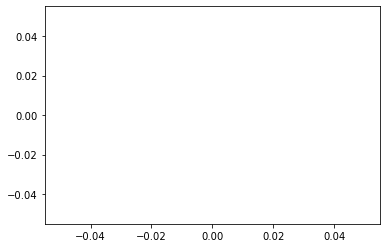

In [63]:
INPUT_DIM = 708
OUT_DIM = 2
H_DIM = 354

dataset = [(features[i][None, ...], train_labels[i]) for i in range(len(train_labels))]

def relu(t):
    return np.maximum(t, 0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def sparse_cross_entropy(z, y):
    return -np.log(z[0, y])

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def relu_diriv(t):
    return (t >= 0).astype(float)

W1 = np.random.randn(INPUT_DIM, H_DIM)
b1 = np.random.randn(1, H_DIM)

W2 = np.random.randn(H_DIM, OUT_DIM)
b2 = np.random.randn(1, OUT_DIM)

ALPHA = 0.001
NUM_EPOCHS = 10

los_arr = []

for ep in tqdm(range(NUM_EPOCHS)):

    for i in range(len(dataset)):

        x, y = dataset[i]

        #Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax(t2)
        E = sparse_cross_entropy(z, y)

        # Backward
        y_full = to_full(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = dE_dt2
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_diriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = dE_dt1

        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2
        
        los_arr.append(E)
        
def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax(t2)
    return z

def calc_accuracy():
    correct = 0
    for x, y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracy = calc_accuracy()
print("Accuracy:", accuracy)

plt.plot(los_arr)
plt.show()

In [64]:

print(los_arr)

[inf, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,